## Prototype end to end Labelator E2E_LBL8R 

### overview.
This notebook protypes a "labelator".  The purpose of a "labelator" is to easily classify _cell types_ for out-of-sample "Test" data. 

Currently we are prototyping with several `anndata` _dataloaders_.  `scvi-tools`, `scarches`, and `anndata` each have an implimenation of a `torch` _dataloader_.   The `scarches` flavor seems to be a good middle ground and then DO have an SCVI implimentation.    Probably will use the _native_ loader for each type, but an `scarches` variant for our simpler models. 

To state our confirmation bias, it impliments the SCVI models which we like.

We will validate potential models and calibrate them with simple expectations using a typical "Train"/"Validate" and "Test"/"Probe" approach.  


Definitions:
- "Train": data samples on which the model being tested is trained.  The `torch lightning` framework used by `scvi-tools` semi-automatically will "validate" to test out-of-sample prediction fidelity during training.
- "Test": held-out samples to test the fidelity of the model.  
- "Probe": data generated externally,which is _probing_ the fidelity of the model to general scRNAseq data.



#### end-to-end
We can also try some _end-to-end_ approaches where a single model takes us from raw counts to category probabilities.
- __naive__
    - boosted trees (e.g. xgboost)
    - cVAE
    - trVAE
- __transfer__
    - scANVI




## Caveats
There are several gotchas to anticipate:
- features.  Currently we are locked into the 3k genes we are testing with.  Handling subsets and supersets is TBC.
- batch.  In principle each "embedding" or decode part of the model should be able to measure a "batch-correction" parameter explicitly.  in scVI this is explicitly _learned_.  However in _naive_ inference mode it should just be an inferred fudge factor.
- noise.  including or not including `doublet`, `mito`, or `ribo` metrics




### List of models

e2e MLP classifier variants:
- raw counts: n=3000 features
- normalized counts (scVI)


In [1]:
import sys

IN_COLAB = "google.colab" in sys.modules
if IN_COLAB:
    !pip uninstall -y typing_extensions
    !pip install --quiet scvi-colab
    from scvi_colab import install
    install()

In [2]:
import torch
import torch.nn as nn
import numpy as np
import scanpy as sc


#### 
import sys
import warnings

import anndata as ad
import matplotlib.pyplot as plt
import numpy as np
# import pandas as pd
import scvi

from pathlib import Path
# import scarches as sca


from lbl8r.utils import (
            mde, 
            make_pc_loading_adata,
            add_predictions_to_adata,
            plot_predictions,
            plot_embedding
    )
from lbl8r import LBL8R



if sys.platform != "darwin":
    torch.set_float32_matmul_precision("medium")  
else:
    print("MPS backend: ",torch.backends.mps.is_available()) #the MacOS is higher than 12.3+
    print("MPS (built): ",torch.backends.mps.is_built()) #MPS is activated

if IN_COLAB:
    from google.colab import drive
    drive.mount('/content/drive')
    

%load_ext autoreload
%autoreload 2


### Load Train, Validate Data 

In [3]:
if IN_COLAB:
    root_path = Path("/content/drive/MyDrive/")
    data_path = root_path / "SingleCellModel/data"
else:
    root_path = Path("../")
    if sys.platform == "darwin":
        data_path = root_path / "data/xylena_raw"
    else:
        data_path = root_path / "data/scdata/xylena"
        raw_data_path = root_path / "data/scdata/xylena_raw"

XYLENA_ANNDATA = "brain_atlas_anndata.h5ad"
XYLENA_METADATA = "final_metadata.csv"
XYLENA_ANNDATA2 = "brain_atlas_anndata_updated.h5ad"

XYLENA_TRAIN = XYLENA_ANNDATA.replace(".h5ad", "_train_cnt.h5ad")
XYLENA_TEST = XYLENA_ANNDATA.replace(".h5ad", "_test_cnt.h5ad")

XYLENA_TRAIN_SPARSE = XYLENA_TRAIN.replace(".h5ad", "_sparse.h5ad")
XYLENA_TEST_SPARSE = XYLENA_TEST.replace(".h5ad", "_sparse.h5ad")

In [4]:
# # subsample 40k cells for prototyping
# subsamples = np.random.choice(train_ad.shape[0], 40_000, replace=False)
# train_ad = train_ad[subsamples,:].copy() # no copy... just alias

In [5]:
CELL_TYPE_KEY = "cell_type"


## model definition

Here we want to classify based on the raw counts

Here we define a helper multilayer perceptron class to use it with a VAE below.

In [6]:
model_path = root_path / "lbl8r_models"
if not model_path.exists():
    model_path.mkdir()

retrain = False
lbl8r_path = model_path / "LBL8R"

In [7]:
lbl8r_path.exists() and not retrain

True

## `AnnData` initialization

In [8]:
filen = data_path / XYLENA_TRAIN
train_ad = ad.read_h5ad(filen)

In [9]:
train_ad.obs["ground_truth"] = train_ad.obs[CELL_TYPE_KEY]


PRED_KEY = "pred_raw"

labels_key = CELL_TYPE_KEY
n_labels = len(train_ad.obs[labels_key].cat.categories)
LBL8R.setup_anndata(train_ad, labels_key=labels_key)

lbl8r_epochs = 200
batch_size = 512

if lbl8r_path.exists() and not retrain:
    raw_lbl8r = LBL8R.load(lbl8r_path, train_ad.copy())
else:
    raw_lbl8r = LBL8R(train_ad, n_labels=n_labels)
    raw_lbl8r.train(
        max_epochs=lbl8r_epochs,
        train_size=0.85,
        batch_size=batch_size,
        early_stopping=True,
    )

INFO     File ../lbl8r_models/LBL8R/model.pt already downloaded                                                    


In [10]:
raw_lbl8r.history.keys()

dict_keys(['train_loss_step', 'validation_loss', 'train_loss_epoch'])

<Axes: xlabel='epoch'>

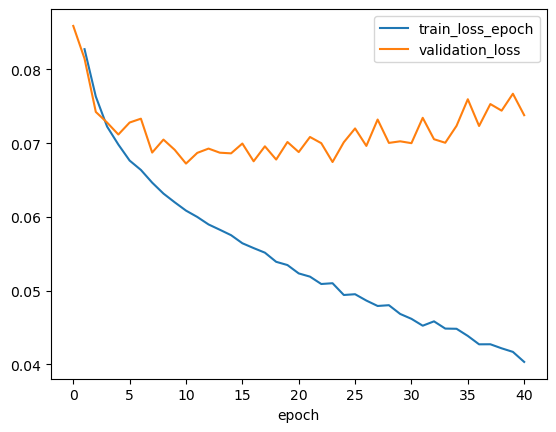

In [11]:
train_loss = raw_lbl8r.history["train_loss_epoch"][1:]
validation_loss = raw_lbl8r.history["validation_loss"]

ax = train_loss.plot()
validation_loss.plot(ax=ax)

In [12]:
predictions = raw_lbl8r.predict(probs=False, soft=True)

train_ad = add_predictions_to_adata(
    train_ad, predictions, insert_key=PRED_KEY, pred_key="label"
)

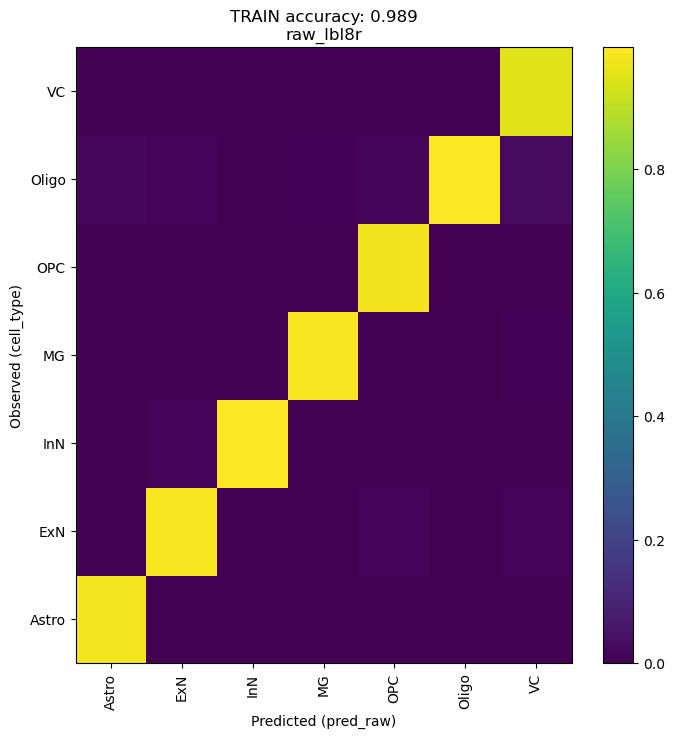

In [13]:
plot_predictions(
    train_ad,
    pred_key=PRED_KEY,
    cell_type_key=CELL_TYPE_KEY,
    model_name="raw_lbl8r",
    title_str="TRAIN",
)

In [14]:
if retrain or not lbl8r_path.exists():
    raw_lbl8r.save(lbl8r_path, overwrite=True)

In [15]:
train_ad.obs["ground_truth"] = train_ad.obs[CELL_TYPE_KEY]


perfoming mde on cuda


/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


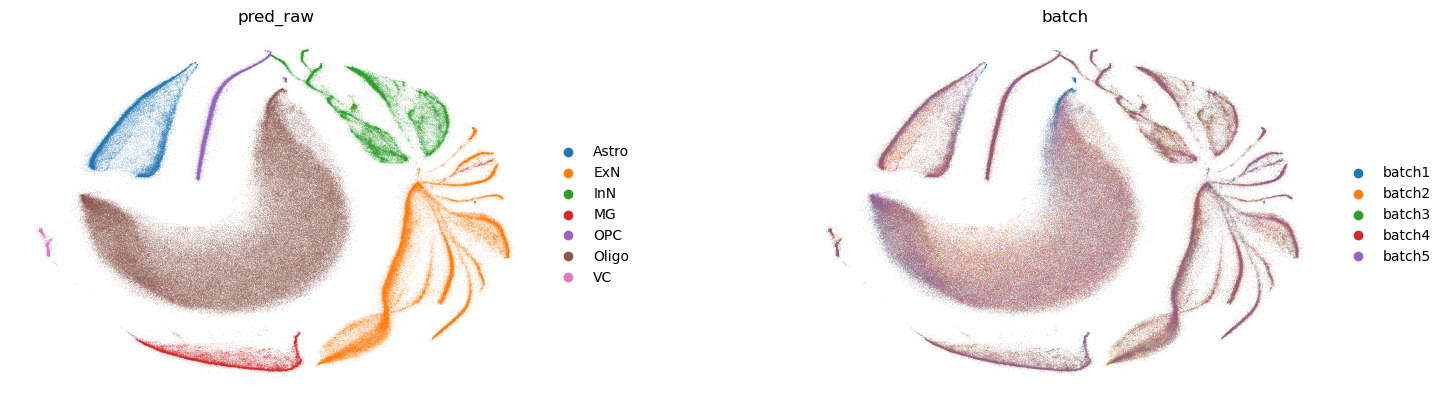

In [16]:
plot_embedding(train_ad,
               basis="X_mde",
                color=[PRED_KEY, "batch"],
                frameon=False,
                wspace=0.35,
                device="cuda")

save versions of test/train with latents and embeddings added


In [17]:
train_ad.write_h5ad(data_path / XYLENA_TEST.replace(".h5ad", "_out.h5ad") )


------------------
Now TEST

In [18]:
filen = data_path / XYLENA_TEST
test_ad = ad.read_h5ad(filen)

# subsamples = np.random.choice(test_ad.shape[0], 10_000, replace=False)
# test_ad = test_ad[subsamples,:] # no copy... just alias
test_ad.obs["ground_truth"] = test_ad.obs[CELL_TYPE_KEY]


In [19]:
LBL8R.setup_anndata(test_ad, labels_key=labels_key)

test_predictions = raw_lbl8r.predict(test_ad, probs=False, soft=True)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


(207726, 3000)


In [20]:
test_ad = add_predictions_to_adata(
    test_ad, test_predictions, insert_key=PRED_KEY, pred_key="label"
)

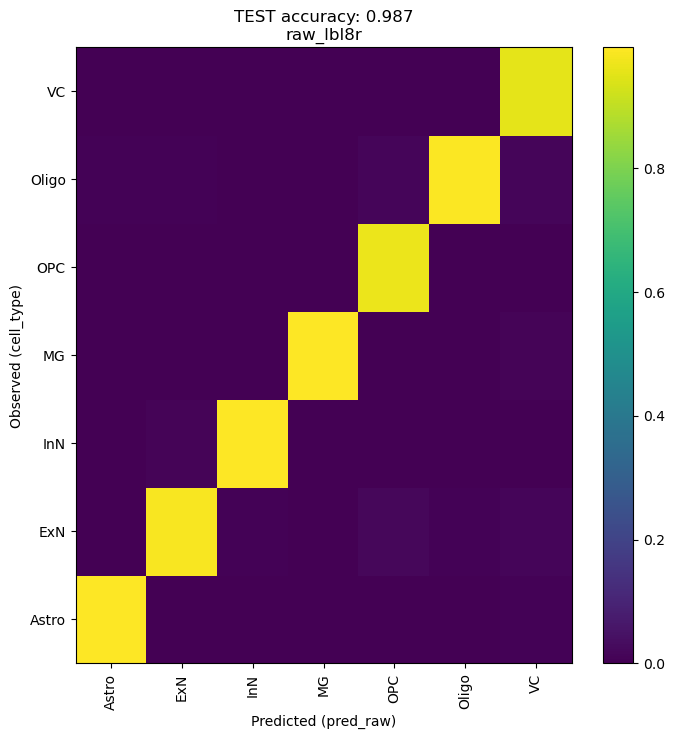

In [21]:
plot_predictions(
    test_ad,
    pred_key=PRED_KEY,
    cell_type_key=CELL_TYPE_KEY,
    model_name="raw_lbl8r",
    title_str="TEST",
)

perfoming mde on cuda


/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


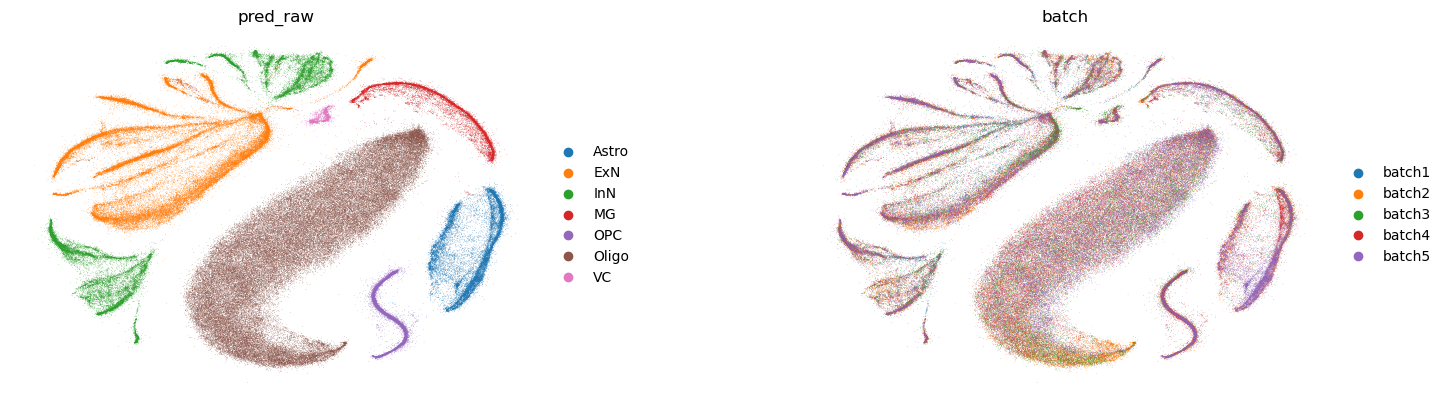

In [22]:
plot_embedding(test_ad,
               basis="X_mde",
                color=[PRED_KEY, "batch"],
                frameon=False,
                wspace=0.35,
                device="cuda")

save versions of test/train with latents and embeddings added


In [23]:
test_ad.write_h5ad(data_path / XYLENA_TEST.replace(".h5ad", "_out.h5ad") )


--------------

## LBL8R on scVI normalized expression  

To give a "baseline" a fair shake its important to use normalized counts.  Using the `scVI` normalization is our best shot... (Although the current models are NOT batch correcting since we don't have a good strategy to do this with probe data)

In [19]:
filen = data_path / "LBL8R"/ XYLENA_TRAIN.replace("_cnt.h5ad", "_scvi_nb_out.h5ad")
exp_train_ad = ad.read_h5ad(filen)
exp_train_ad.obs["ground_truth"] = exp_train_ad.obs[CELL_TYPE_KEY]


In [20]:
labels_key = CELL_TYPE_KEY
n_labels = len(exp_train_ad.obs[labels_key].cat.categories)
LBL8R.setup_anndata(exp_train_ad, labels_key=labels_key)

exp_lbl8_path = model_path / "LBL8R_scVInorm"
if exp_lbl8_path.exists() and not retrain:
    exp_lbl8r = LBL8R.load(exp_lbl8_path, exp_train_ad.copy())
else:
    exp_lbl8r = LBL8R(exp_train_ad, n_labels=n_labels)
    exp_lbl8r.train(
        max_epochs=lbl8r_epochs,
        train_size=0.85,
        batch_size=batch_size,
        early_stopping=True,
    )

GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Epoch 1/200:   0%|          | 0/200 [00:00<?, ?it/s]

Epoch 200/200: 100%|██████████| 200/200 [04:10<00:00,  1.24s/it, v_num=1, train_loss_step=0.175, train_loss_epoch=0.0672] 

`Trainer.fit` stopped: `max_epochs=200` reached.


Epoch 200/200: 100%|██████████| 200/200 [04:10<00:00,  1.25s/it, v_num=1, train_loss_step=0.175, train_loss_epoch=0.0672]


In [21]:
predictions = exp_lbl8r.predict(probs=False, soft=True)

norm_train_ad = add_predictions_to_adata(
    exp_train_ad, predictions, insert_key=PRED_KEY, pred_key="label"
)

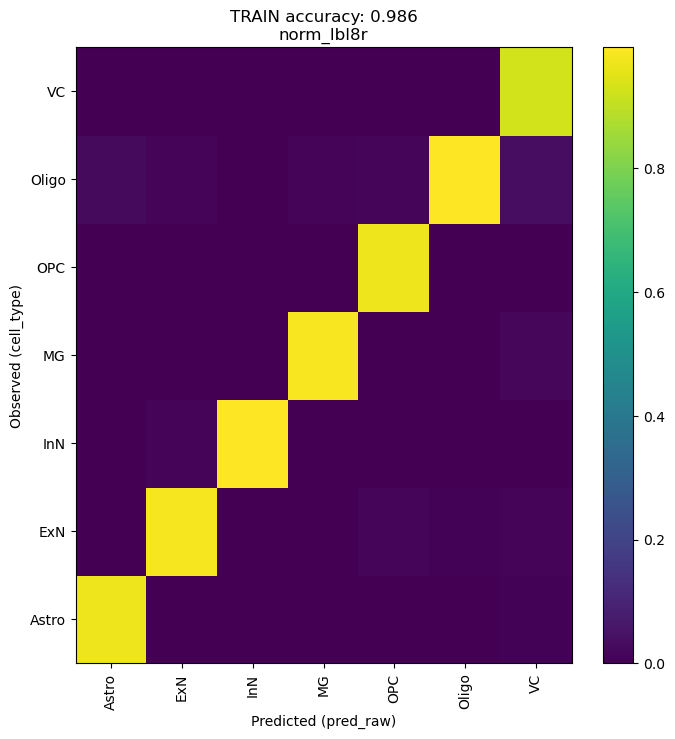

In [22]:
plot_predictions(
    norm_train_ad,
    pred_key=PRED_KEY,
    cell_type_key=CELL_TYPE_KEY,
    model_name="norm_lbl8r",
    title_str="TRAIN",
)

In [23]:
if retrain and not exp_lbl8_path.exists():
    exp_lbl8r.save(exp_lbl8_path, overwrite=True)

In [24]:
exp_train_ad

AnnData object with n_obs × n_vars = 502085 × 10
    obs: 'seurat_clusters', 'cell_type', 'sample', 'doublet_score', 'nCount_RNA', 'nFeature_RNA', 'percent.mt', 'percent.rb', 'batch', 'sample_other', 'S.Score', 'G2M.Score', 'Phase', 'RNA_snn_res.0.3', 'seurat_clusters_other', 'ExN1', 'InN2', 'MG3', 'Astro4', 'Oligo5', 'OPC6', 'VC7', 'type', 'UMAP_1', 'UMAP_2', 'clean', 'test', 'train', 'tmp', '_scvi_batch', '_scvi_labels', 'pred', 'ground_truth', 'pred_raw'
    uns: '_scvi_uuid', '_scvi_manager_uuid'
    obsm: 'X_pca', 'X_scVI'

perfoming mde on cuda


/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


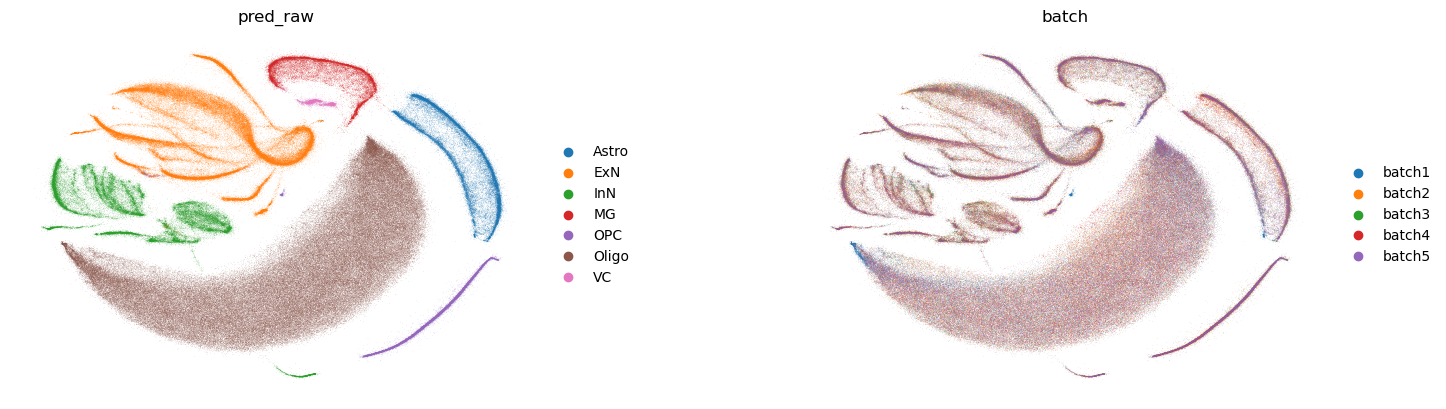

In [25]:
plot_embedding(exp_train_ad,
               basis="X_mde",
                color=[PRED_KEY, "batch"],
                frameon=False,
                wspace=0.35,
                device="cuda")

save versions of test/train with latents and embeddings added


In [28]:
exp_train_ad.write_h5ad(data_path / XYLENA_TRAIN.replace(".h5ad", "_scvi_nb_out.h5ad") )


test scvi normalized loadings

In [29]:

filen = data_path / "LBL8R" / XYLENA_TEST.replace("_cnt.h5ad", "_scvi_nb_out.h5ad")
exp_test_ad = ad.read_h5ad(filen)

exp_test_ad.obs["ground_truth"] = exp_test_ad.obs[CELL_TYPE_KEY]

In [30]:
LBL8R.setup_anndata(exp_test_ad, labels_key=labels_key)

test_predictions = exp_lbl8r.predict(exp_test_ad, probs=False, soft=True)

norm_test_ad = add_predictions_to_adata(
    exp_test_ad, test_predictions, insert_key=PRED_KEY, pred_key="label"
)

INFO     Input AnnData not setup with scvi-tools. attempting to transfer AnnData setup                             


(207726, 10)


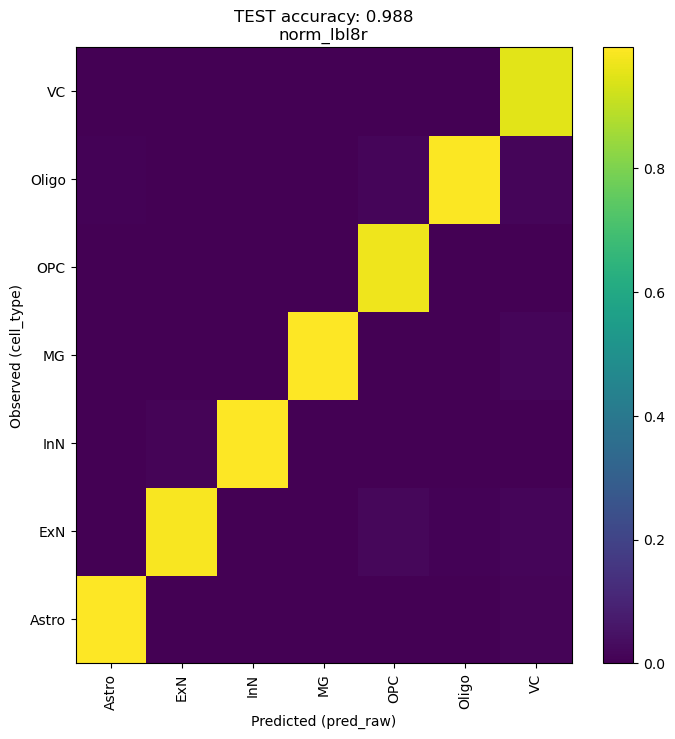

In [31]:
plot_predictions(
    exp_test_ad,
    pred_key=PRED_KEY,
    cell_type_key=CELL_TYPE_KEY,
    model_name="norm_lbl8r",
    title_str="TEST",
)

perfoming mde on cuda


/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(
/home/ergonyc/mambaforge/envs/scverse11/lib/python3.11/site-packages/scanpy/plotting/_tools/scatterplots.py:394: UserWarning: No data for colormapping provided via 'c'. Parameters 'cmap' will be ignored
  cax = scatter(


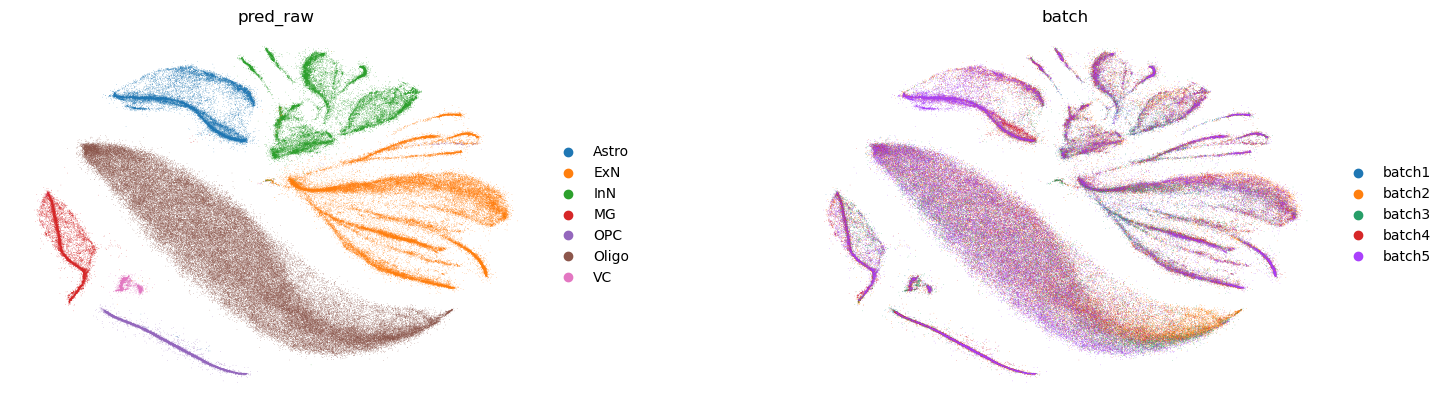

In [32]:
plot_embedding(exp_test_ad,
               basis="X_mde",
                color=[PRED_KEY, "batch"],
                frameon=False,
                wspace=0.35,
                device="cuda")

save versions of test/train with latents and embeddings added


In [33]:
exp_test_ad.write_h5ad(data_path / XYLENA_TEST.replace(".h5ad", "_scvi_nb_out.h5ad") )
